In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
from sklearn.model_selection import train_test_split

### Load all the data for each subject

each mat.file represent 1 subject doing 1 activity

In [2]:
path = "../USC-HAD/"
activity = []
activity_num = []
sensor_reading = []
subject_num = []
for root, directories, files in os.walk(path,topdown=True): ### directories = "Subject2" e.g
    for name in files:
        if ".mat" in name:
            mat = loadmat(os.path.join(root,name))
            activity.append(mat["activity"][0])
            sensor_reading.append(mat["sensor_readings"])
            subject_num.extend(mat["subject"])
            if mat.get("activity_number") is None: ### missing activity number
                activity_num.append("99")
            else:
                activity_num.append(mat["activity_number"][0])
            

In [3]:
acc_x = []
acc_y = []
acc_z = []
gyro_x = []
gyro_y = []
gyro_z = []
subjects = []
labels = []
for i in range(len(sensor_reading)): ### for each reading in 840 total reading
    for readings in sensor_reading[i]: ### sensor_reading[0] -> acc
        acc_x.append(readings[0]) ### 
        acc_y.append(readings[1])
        acc_z.append(readings[2])
        gyro_x.append(readings[3])
        gyro_y.append(readings[4])
        gyro_z.append(readings[5])
        subjects.append(subject_num[i])
        labels.append(activity_num[i])

### Create Dataframe

In [4]:
df = pd.DataFrame({"Subject_Id":subjects,"acc_x":acc_x,"acc_y":acc_y,"acc_z":acc_z,
                  "gyro_x":gyro_x,"gyro_y":gyro_y,"gyro_z":gyro_z,"labels":labels})

In [5]:
len(df)

2811490

In [6]:
df1 = df[(df.labels != "99")]

In [7]:
len(df1)

2809281

In [8]:
no_labels = df[(df.labels=="99")]

In [9]:
len(no_labels)

2209

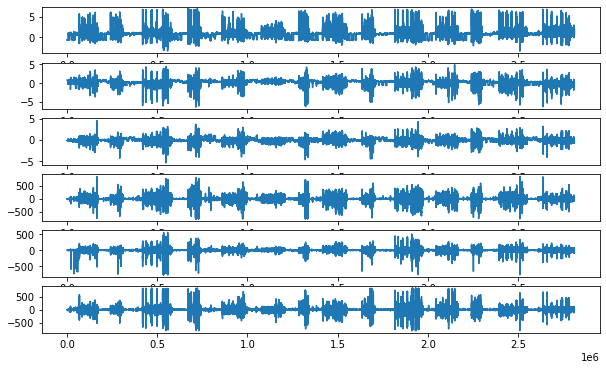

In [10]:
plt.figure(figsize=(10,6))
plt.subplot(6,1,1)
plt.plot(df1["acc_x"])
plt.subplot(6,1,2)
plt.plot(df1["acc_y"])
plt.subplot(6,1,3)
plt.plot(df1["acc_z"])
plt.subplot(6,1,4)
plt.plot(df1["gyro_x"])
plt.subplot(6,1,5)
plt.plot(df1["gyro_y"])
plt.subplot(6,1,6)
plt.plot(df1["gyro_z"])
plt.show()

### Signal Segmentation

68 number of samples in each timestep window size = 50%

In [ ]:
def window(data,window_size):
    start = 0
    while start < len(data):
        yield int(start),int(start+window_size) ### generate(start,end)
        start += (window_size/2) ### 50% overlap

In [ ]:
def signal_segmentation(data,window_size):
    segment = np.empty((0,window_size,6)) ### number of sample,measurements,no. samples in window_size
    labels = np.empty((0))
    subjects = np.empty((0))
    for (start,end) in window(data["labels"],window_size):
        print(start,end)
        acc_x = data["acc_x"][start:end]
        acc_y = data["acc_y"][start:end]
        acc_z = data["acc_z"][start:end]
        gyro_x = data["gyro_x"][start:end]
        gyro_y = data["gyro_y"][start:end]
        gyro_z = data["gyro_z"][start:end]
        if (len(data["labels"][start:end])==window_size):
            segment = np.vstack((segment,np.dstack((acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z)))) ###(1,128,6)
            labels = np.append(labels,np.bincount(data["labels"][start:end]).argmax()) ###return most frequent label
            subjects = np.append(subjects,np.bincount(data["Subject_Id"][start:end]).argmax())
    return segment,labels,subjects

In [ ]:
segments,labels,subjects = signal_segmentation(df1,64) ###window size =64

In [ ]:
segments = np.swapaxes(segments, 1,2) ### reshape from (43894,128,6) -> (43894,6,128)
labels = labels.astype(int)
subjects = subjects.astype(int)

In [ ]:
np.save("segments_data_64",segments) ### save np array
np.save("labels_64",labels)
np.save("subjects_64",subjects)

In [11]:
seg_data = np.load("segments_data_128.npy") ### load np array
labels = np.load("labels_128.npy")
subjects = np.load("subjects_128.npy")

In [12]:
print(seg_data.shape)
print(labels.shape)
print(subjects.shape)

(43894, 6, 128)
(43894,)
(43894,)


### Jiang and Yin's algorithm

In [13]:
seg_data_list = seg_data.tolist()
label_list = labels.tolist()

In [14]:
def order_SI(raw_sig):
    type_sensor = len(raw_sig)
    pair_list = []
    
    for i in range (1,type_sensor):
        temp_list = []
        temp_list = [temp_list+[i,j+1] for j in range(i,type_sensor)]
        pair_list += temp_list
        
    sig_list = pair_list[0]
    del pair_list[0]
    
    while pair_list:
        for pair in pair_list:
               
            if sig_list[0] == pair[0]:
                sig_list.insert(0,pair[1])
                pair_list.remove(pair)
                break
                
            elif sig_list[0] == pair[1]:
                sig_list.insert(0,pair[0])
                pair_list.remove(pair)
                break
                
            elif sig_list[-1] == pair[0]:
                sig_list.append(pair[1])
                pair_list.remove(pair)
                break
                
            elif sig_list[-1] == pair[1]:
                sig_list.append(pair[0])
                pair_list.remove(pair)
                break
                  
            elif pair == pair_list[-1]:
                sig_list.append(pair[0])
                sig_list.append(pair[1])
                pair_list.remove(pair)
                break
                
    left_sig_list = []
    right_sig_list = []
    
    left_sig_list.append(sig_list[1])
    for i in range(len(sig_list)-1):
        left_sig_list.append(sig_list[i])
     
    right_sig_list.append(sig_list[1])
    for i in range(len(sig_list)-2):
        right_sig_list.append(sig_list[i+2])
    right_sig_list.append(sig_list[0])
    
    return sig_list,left_sig_list,right_sig_list

In [15]:
sig_list,left_sig_list,right_sig_list = order_SI(seg_data_list[0])

In [16]:
seg_raw_signal = []
for i in range(len(seg_data_list)):
    seg_raw_signal.append([seg_data_list[i][sig_order-1] for sig_order in sig_list])

In [17]:
left_seg_raw_signal = []
for i in range(len(seg_data_list)):
    left_seg_raw_signal.append([seg_data_list[i][sig_order-1] for sig_order in left_sig_list])

In [18]:
right_seg_raw_signal = []
for i in range(len(seg_data_list)):
    right_seg_raw_signal.append([seg_data_list[i][sig_order-1] for sig_order in right_sig_list])

In [19]:
seg_raw_signal_np = np.array(seg_raw_signal)
left_seg_raw_signal_np = np.array(left_seg_raw_signal)
right_seg_raw_signal_np = np.array(right_seg_raw_signal)

In [20]:
stack_raw_signal = np.dstack((left_seg_raw_signal_np,seg_raw_signal_np,right_seg_raw_signal_np))

In [21]:
stack_raw_signal.shape

(43894, 18, 384)

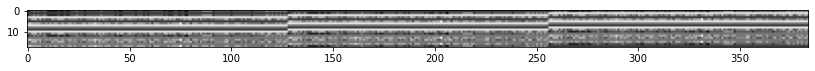

In [22]:
plt.figure(figsize = (14,10))
plt.imshow(stack_raw_signal[label_list.index(10)],cmap="gray")

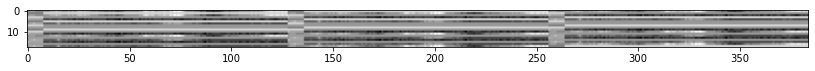

In [23]:
plt.figure(figsize = (14, 7))
plt.imshow(stack_raw_signal[label_list.index(8)],cmap="gray")

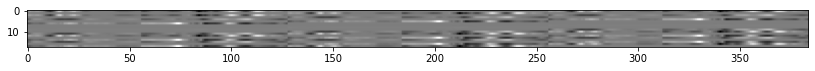

In [24]:
plt.figure(figsize = (14, 7))
plt.imshow(stack_raw_signal[label_list.index(1)],cmap="gray")

### DFT

In [25]:
print(stack_raw_signal.shape)

(43894, 18, 384)


In [26]:
stack_raw_signal_dft = (np.abs(np.fft.fft2(stack_raw_signal)))

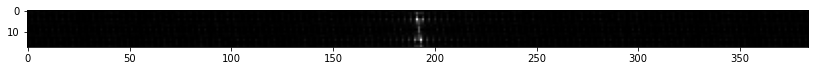

In [27]:
plt.figure(figsize = (14, 7))
fshift_SI_10 = np.fft.fftshift(stack_raw_signal_dft[label_list.index(10)])
plt.imshow(fshift_SI_10,cmap="gray")
plt.show()

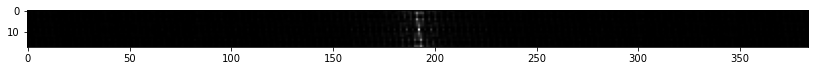

In [28]:
plt.figure(figsize = (14, 7))
fshift_SI_8 = np.fft.fftshift(stack_raw_signal_dft[label_list.index(8)])
plt.imshow(fshift_SI_8,cmap="gray")
plt.show()

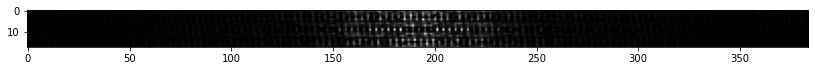

In [29]:
plt.figure(figsize = (14, 7))
fshift_SI_1 = np.fft.fftshift(stack_raw_signal_dft[label_list.index(1)])
plt.imshow(fshift_SI_1,cmap="gray")
plt.show()

### train-test split

In [ ]:
train_features,test_features,train_labels,test_labels = train_test_split(stack_raw_signal_dft, labels,
                                                                         test_size=0.3, random_state=42)

In [ ]:
np.save("train_features_USC_mod_al_64.npy",train_features)
np.save("test_features_USC_mod_al_64.npy",test_features)
np.save("train_labels_USC_mod_al_64.npy",train_labels)
np.save("test_labels_USC_mod_al_64.npy",test_labels)

In [ ]:
#print(np.load("usc_multi/train_features_USC_mod_al_64.npy").shape)
#print(np.load("test_features_USC.npy").shape)
#print(np.load("train_labels_USC.npy").shape)
#print(np.load("test_labels_USC.npy").shape)


In [ ]:
train_labels

In [ ]:
train_labels_nl